# Growth Mechanism with Details

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data , fit_exp_function
from m3_learning.RHEED.Packed_functions import decay_curve_examples

printing = printer(basepath = 'Figures/3.Growth_mechanism/')
printing_plot = printer(basepath = 'Figures/3.Growth_mechanism/', fileformats=['png'], dpi=1200)
if not os.path.isdir('Saved_data'): os.mkdir('Saved_data')
set_style("printing")
random_seed(seed=42)

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


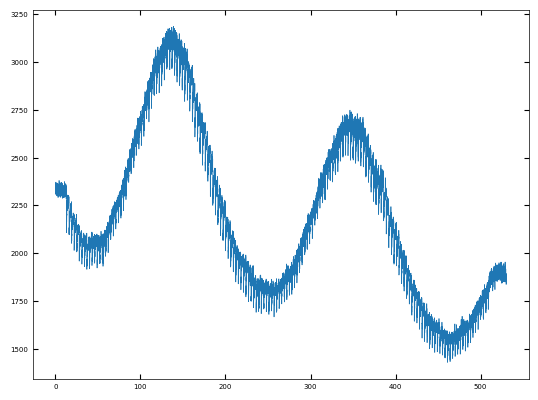

In [126]:
data = np.loadtxt('./Datasets/8-21-2023/STO 650C PeterManualRelaxation (.33Hz).txt')
sample_x, sample_y = data[:,0], data[:,1]
plt.plot(sample_x, sample_y)

In [105]:
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

curve_x, curve_y = sample_x, sample_y

camera_freq=30
laser_freq=0.33
step_size=3
prominence=10
dist = int(camera_freq/laser_freq*0.6)
step = np.hstack((np.ones(step_size), -1*np.ones(step_size)))
dary_step = np.convolve(curve_y, step, mode='valid')
dary_step = np.abs(dary_step)

filtered_curve_y = dary_step/step_size
x_peaks, properties = signal.find_peaks(filtered_curve_y, prominence=prominence, distance=dist)
x_peaks = x_peaks[x_peaks>dist]
x_peaks = x_peaks[x_peaks<len(curve_y)-dist]

# get all partial curve 
xs, ys = [], []
for i in range(1, len(x_peaks)):
    xs.append(list(curve_x[5+x_peaks[i-1]:x_peaks[i]]))
    ys.append(list(curve_y[5+x_peaks[i-1]:x_peaks[i]]))

[[2.284, 2.317, 2.351, 2.383, 2.416, 2.449, 2.482, 2.516, 2.549, 2.582, 2.615, 2.647, 2.68, 2.714, 2.746, 2.78, 2.813, 2.846, 2.879, 2.913, 2.945, 2.978, 3.011, 3.044, 3.077, 3.11, 3.143, 3.177, 3.21, 3.243, 3.276, 3.309, 3.343, 3.376, 3.409, 3.442, 3.475, 3.508, 3.542, 3.575, 3.607, 3.641, 3.673, 3.706, 3.739, 3.773, 3.806, 3.839, 3.872, 3.905, 3.938, 3.971, 4.004, 4.037, 4.07, 4.104, 4.137, 4.17, 4.203], [13.071, 13.105, 13.138, 13.171, 13.204, 13.237, 13.27, 13.304, 13.337, 13.37, 13.403, 13.436, 13.469, 13.502, 13.535, 13.569, 13.602, 13.634, 13.667, 13.7, 13.733, 13.767, 13.8, 13.833, 13.866, 13.899, 13.932, 13.966, 13.998, 14.031, 14.071, 14.098, 14.13, 14.164, 14.197, 14.23, 14.263, 14.297, 14.33, 14.363, 14.395, 14.429, 14.463, 14.496, 14.529, 14.561, 14.595, 14.627, 14.66, 14.693, 14.727, 14.76, 14.793, 14.825, 14.858, 14.891, 14.925, 14.958, 14.991, 15.024, 15.057, 15.091, 15.124, 15.157, 15.19, 15.222, 15.256, 15.289, 15.322, 15.355, 15.388, 15.422, 15.455, 15.488, 15.521, 1

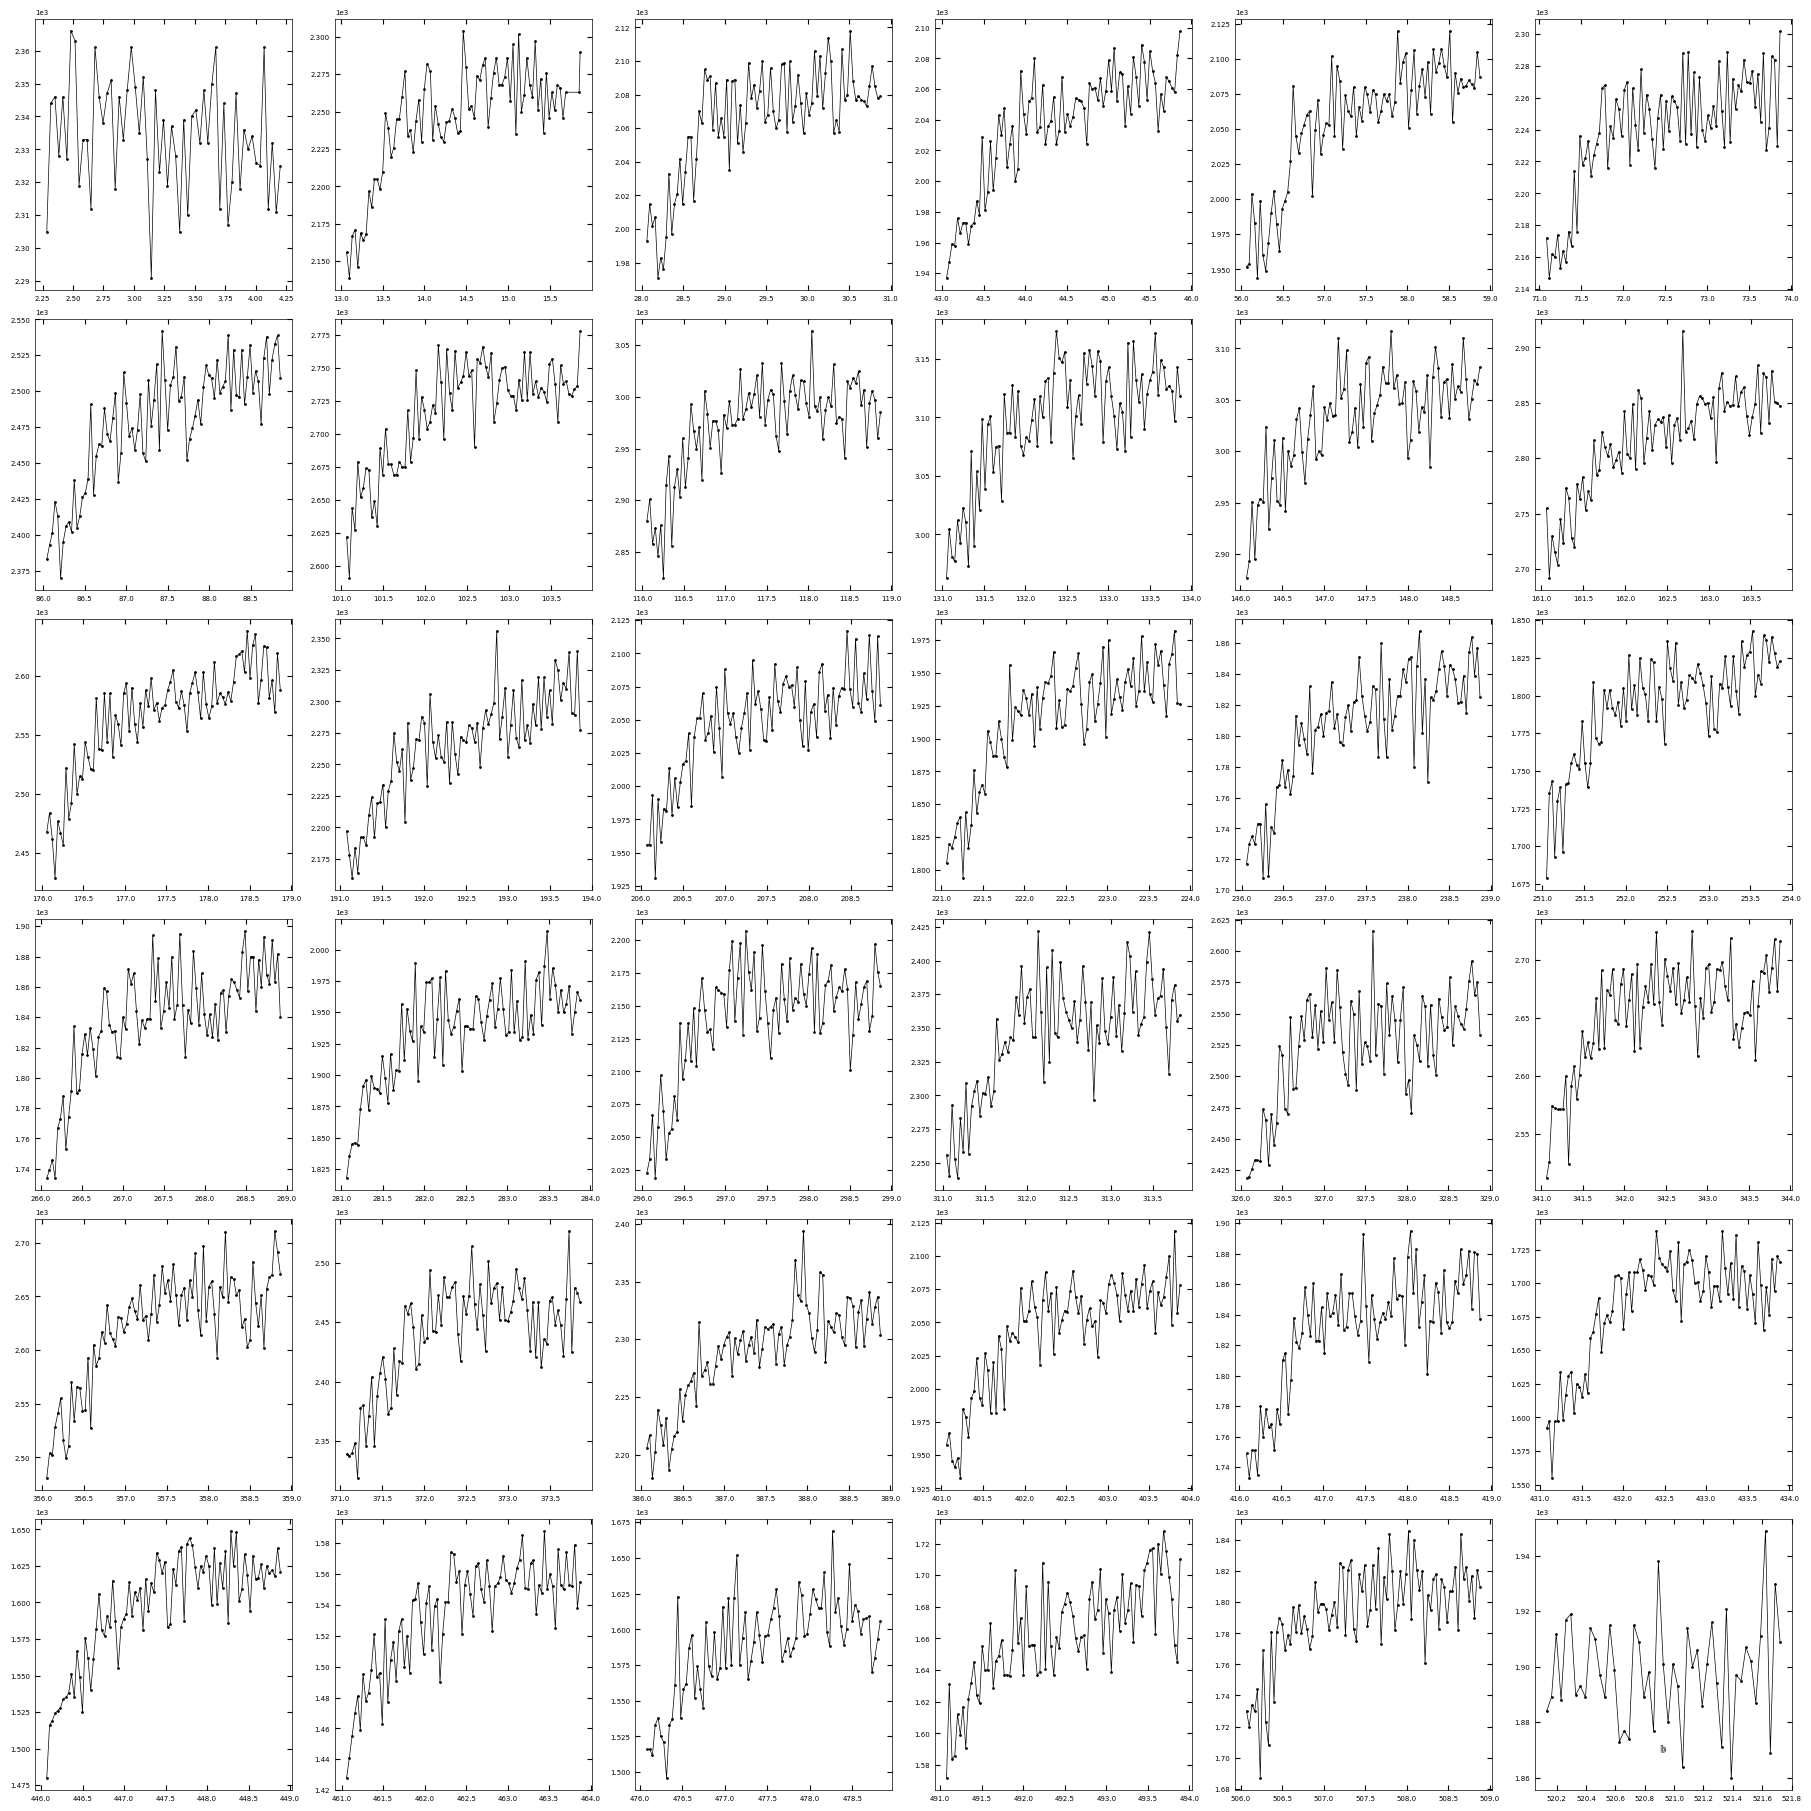

In [106]:
xs_sample, ys_sample = xs[::5], ys[::5]
print(xs_sample)
fig, axes = layout_fig(len(ys_sample), mod=6, figsize=None, layout='compressed')
Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

89


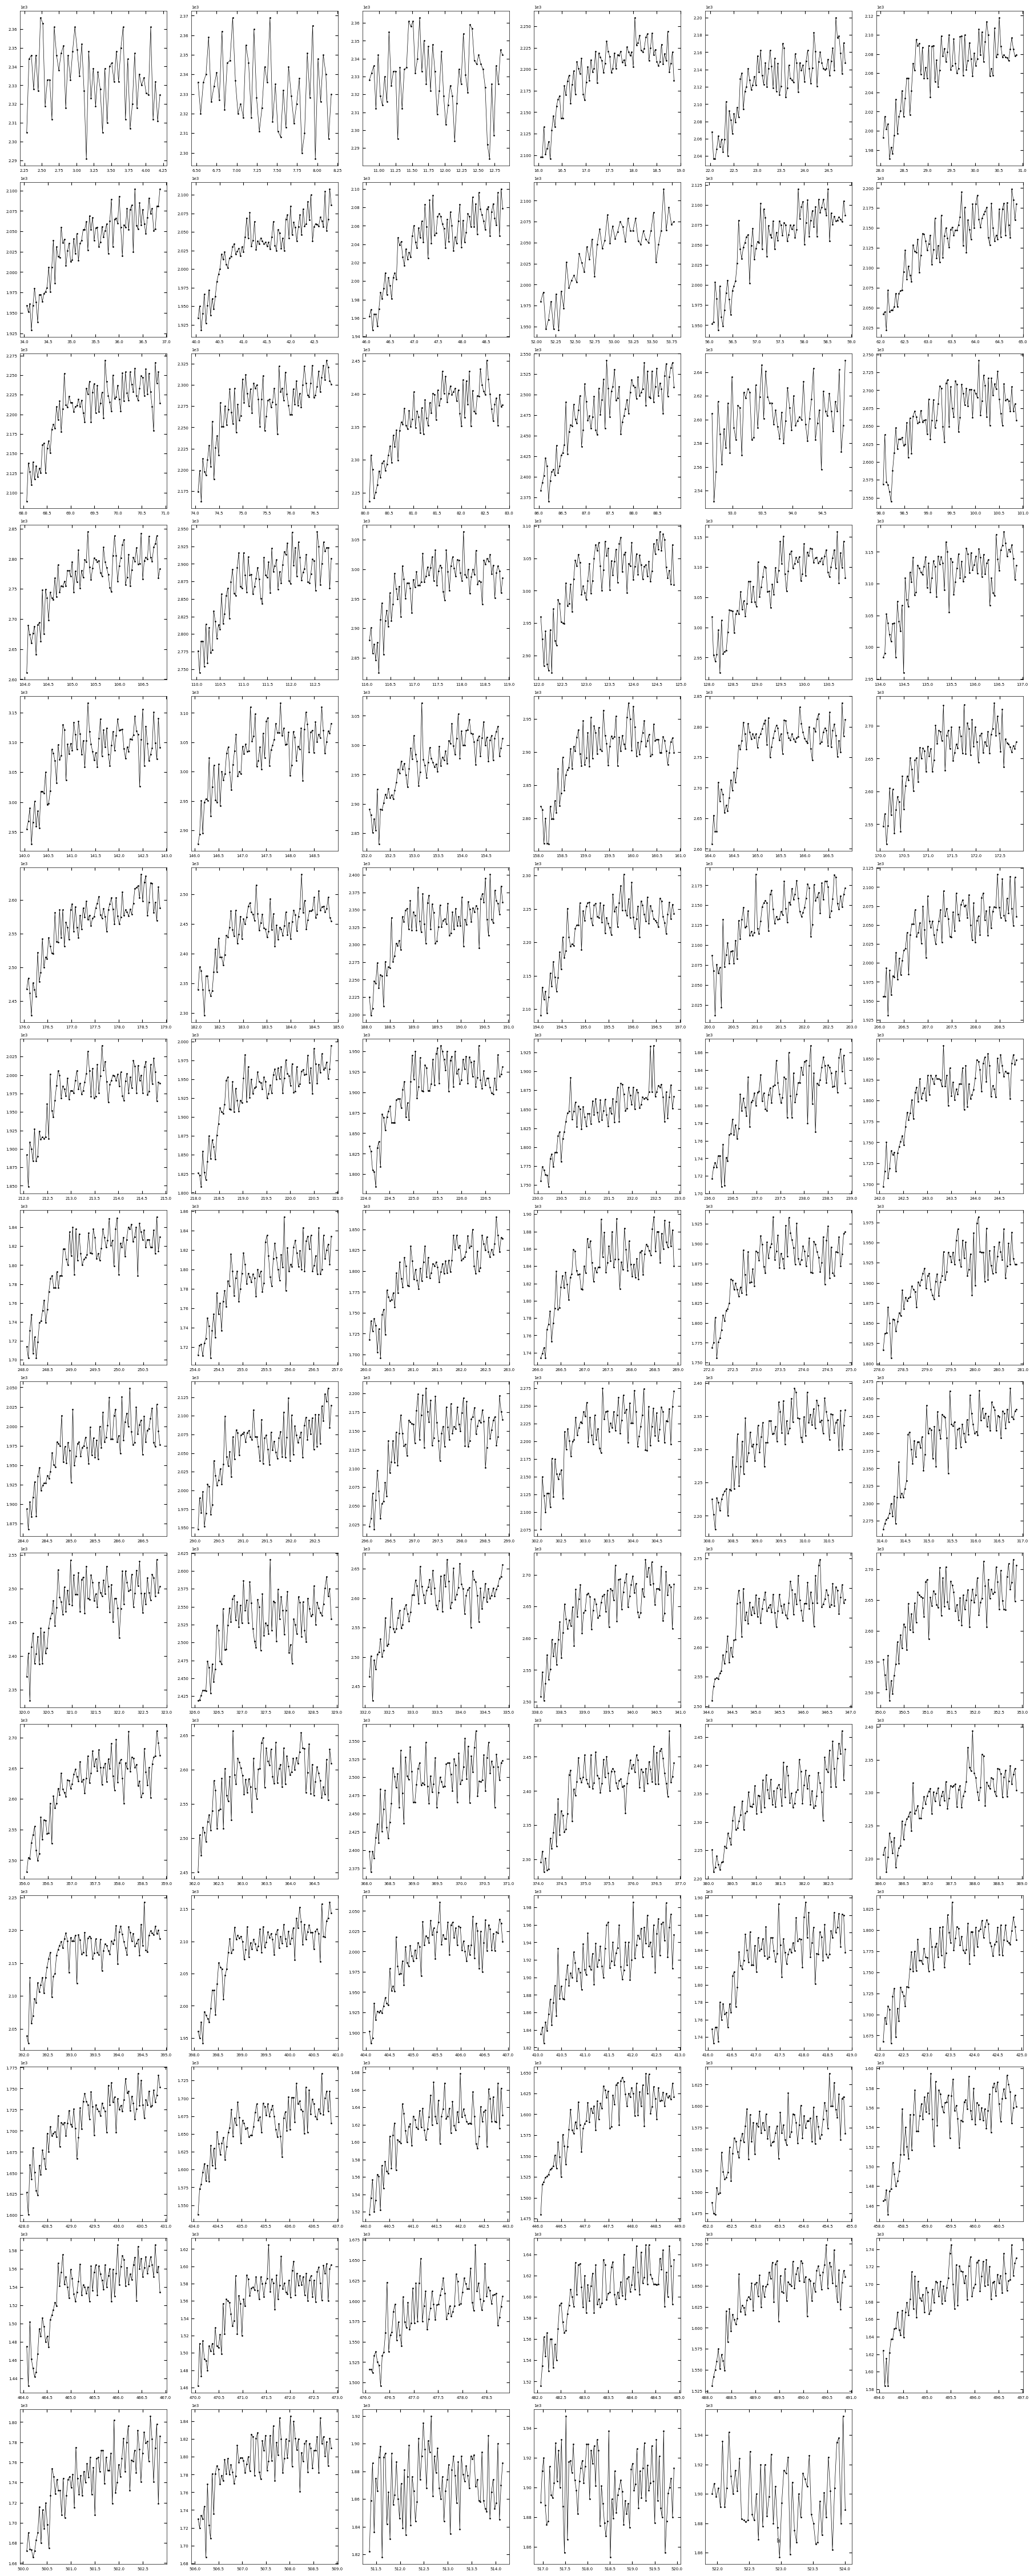

In [107]:
x_peaks, xs, ys = detect_peaks(x, y, camera_freq=30, laser_freq=0.33, step_size=3, prominence=10)

xs_sample, ys_sample = xs[::2], ys[::2]

fig, axes = layout_fig(len(ys_sample), mod=6, figsize=None, layout='compressed')
print(len(ys_sample))
Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [108]:
length_list = []
for xi in xs:
    length_list.append(len(xi))
print(np.mean(length_list))

83.97752808988764


In [127]:
fit_settings = {'savgol_window_order': (15, 3), 'pca_component': 10, 'I_diff': 15000, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.1, 0.4, 0.1]}
x_end = 0

parameters_all, x_list_all = [], []
xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all = [], [], [], [], [], []
labels_all, losses_all =  [], []

x_peaks, xs, ys = detect_peaks(x, y, camera_freq=30, laser_freq=0.33, step_size=3, prominence=10)

xs, ys = process_rheed_data(xs, ys, length=80, savgol_window_order=fit_settings['savgol_window_order'], 
                            pca_component=fit_settings['pca_component'])        

# fit exponential function
parameters, info = fit_exp_function(xs, ys, growth_name='growth_1', fit_settings=fit_settings)        
parameters_all.append(parameters)
xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses = info
xs_all.append(xs)
ys_all.append(ys)
ys_fit_all+=ys_fit
ys_nor_all+=ys_nor
ys_nor_fit_all+=ys_nor_fit
ys_nor_fit_failed_all+=ys_nor_fit_failed
labels_all += labels
losses_all += losses

x_list = x_peaks[:-1] + x_end
x_end = round(x_end + (len(sample_x)+0)/30, 2)
x_list_all.append(x_list)
    
parameters_all = np.concatenate(parameters_all, 0)
x_list_all = np.concatenate(x_list_all)[:len(parameters_all)]
xs_all = np.concatenate(xs_all)
ys_all = np.concatenate(ys_all)
ys_nor_all = np.array(ys_nor_all)
ys_nor_fit_all = np.array(ys_nor_fit_all)
losses_all = np.array(losses_all)
ys_nor_fit_all_failed = np.array(ys_nor_fit_failed_all)

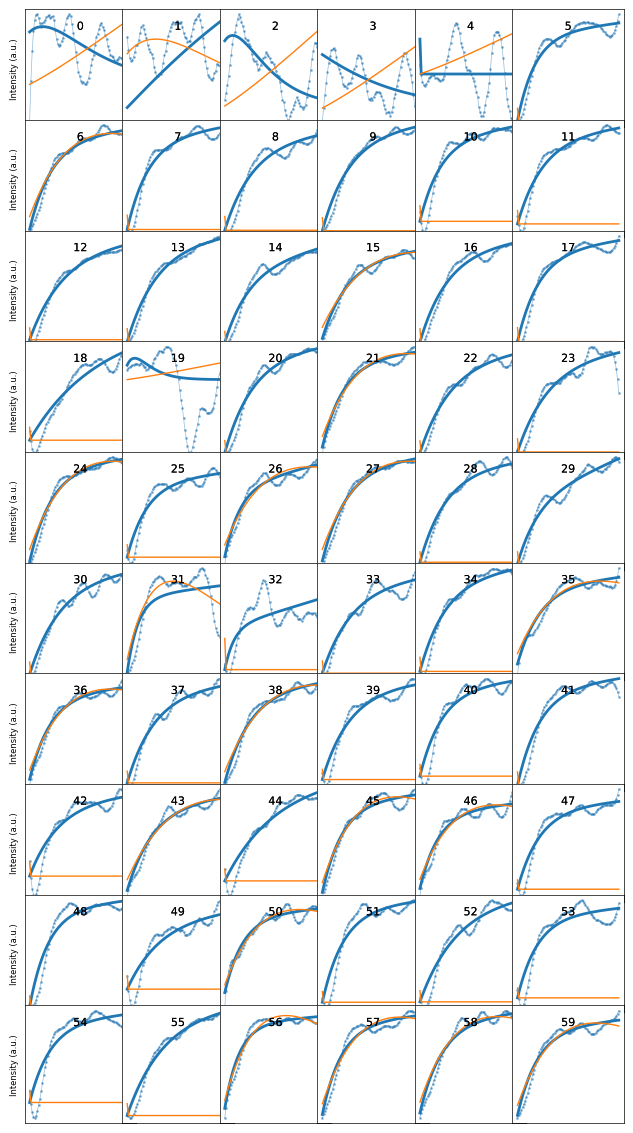

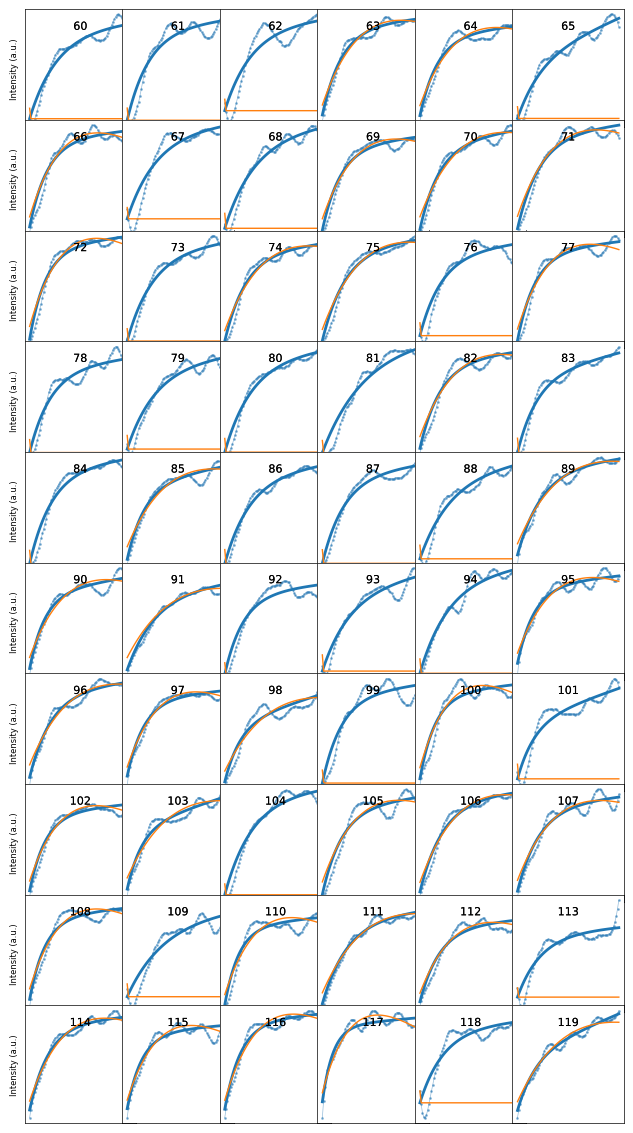

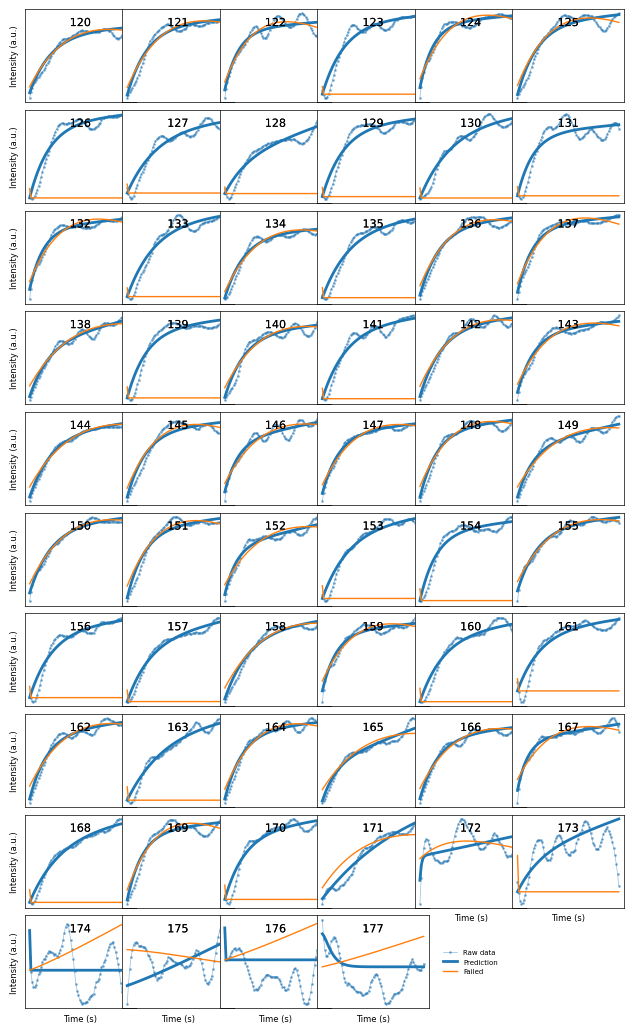

In [110]:
Viz.plot_fit_details(xs_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, index_list=range(len(xs_all)))

In [113]:
len(sample_x), len(sample_y)

(16018, 16018)

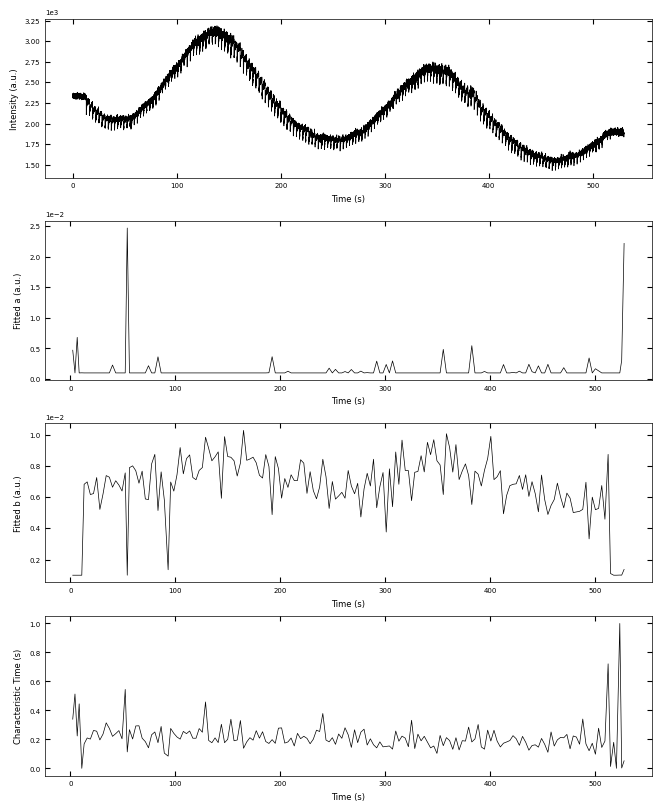

In [129]:
fig, axes = layout_fig(4, 1, figsize=(6.5, 2*4))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_list_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted a (a.u.)')
Viz.plot_curve(axes[2], x_list_all, parameters_all[:,1], plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted b (a.u.)')
Viz.plot_curve(axes[3], x_list_all, parameters_all[:,2], plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)')
plt.show()

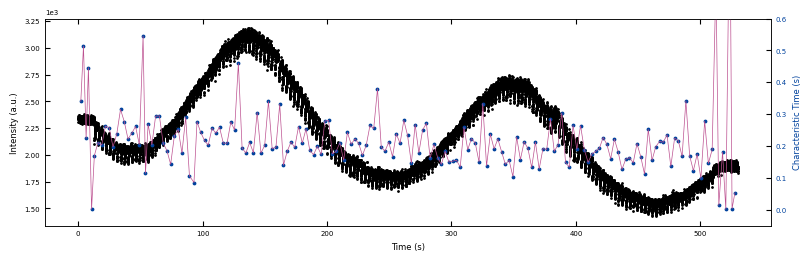

In [130]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2.5), layout='compressed')
ax1.scatter(sample_x, sample_y, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', ticks_both_sides=False)

ax2 = ax1.twinx()
ax2.scatter(x_list_all, parameters[:,2], color=seq_colors[0], s=3)
ax2.plot(x_list_all,  parameters[:,2], color='#bc5090', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.6), ticks_both_sides=False)
ax2.tick_params(axis="y", color='k', labelcolor=seq_colors[0])
ax2.set_ylabel('Characteristic Time (s)', color=seq_colors[0])
plt.show()